# Visual Search using Tensorflow

<hr>

- We will use embeddings and Transfer Learning to identify similar items

- Then this information will be used to recommend similar content in Recommendation System

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

## What is Embedding ?

<hr>

An embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. Embeddings make it easier to do machine learning on large inputs like sparse vectors representing words. Ideally, an embedding captures some of the semantics of the input by placing semantically similar inputs close together in the embedding space. An embedding can be learned and reused across models.

<br>

Neural network embeddings have 2 primary purposes:

- Dimensionality Reduction — **more efficient** representation

- Finding nearest neighbors in the embedding space - These can be used to make recommendations based on user interests or cluster categories.

In [ ]:
## --------------------------------------------------------------------------------------------------------------------- ##

## Transfer Learning

<hr>

If we want to make a machine learning model from scratch, we must collecting training dataset, do feature engineering, tuning a hyperparameter then test the model quality. This can consume a lot of time, energy even money if you train in the cloud service use GPU or TPU. More importantly, this model might not give satisfying results in the end.

Do you know ImageNet challenge?

![imagenet](https://miro.medium.com/max/1276/1*OHRF4gFSRuhuJyu5zs7PSA.jpeg)

Let's think about this: "Can our laptop train deep learning model use 1.200.000 image dataset?". Due of RAM limitations we cannot do this, instead we must use cloud computing to train this model. Also is really hard to tuning a model that can make great predictions on 1.000 objects

So what's the solution?

Big company or famous university like Google, Facebook, Stanford, MIT etc already make a great Deep Learning model in computer vision and NLP. These models are trained using huge dataset, tuned by best researcher in the world, also using a very expensive computer or cloud TPU. Thankfully these pre-trained models are open-source, so we can download and use it for free

1. We can use pre-trained model with pretrained weights to directly make a prediction
1. We also can use that model without load pretrained-weights
1. Even we can changing and retraining different task-specific layers or the output layer

<div class="alert alert-info"> <b>Transfer learning has several benefits, but the main advantages are  saving training time, better performance of neural networks (in most cases), and not needing a lot of data</b> </div>

## Data Cleaning

1. Due to ram limitations in kaggle kernel (max 16GB), i only use 15000 images in dataset
1. There are some error rows in dataset, we must use error_bad_lines=False to for automatic skip rows these rows

In [2]:
###
style_df = pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/styles.csv', error_bad_lines=False)
print(style_df.shape)

(44424, 10)


b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [3]:
# style_df = pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/styles.csv', error_bad_lines=False, nrows=20000)
images_df = pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/images.csv')

In [4]:
# Because of some rows error, we must reset_index
style_df = style_df.reset_index(drop=True)

# Make image_path feature
style_df['image_path'] = style_df['id'].apply(lambda row: '/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/images/' + str(row) + '.jpg')

In [5]:
style_df.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  \
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt   
1  2012.0  Casual             Peter England Men Party Blue Jeans   
2  2016.0  Casual                       Titan Women Silver Watch   
3  2011.0  Casual  Manchester United Men Solid Black Track Pants   
4  2012.0  Casual                          Puma Men Grey T-shirt   

                                          image_path  
0  /kaggle/input/fashion-product-images-dataset/f...  
1  /kaggle/input/fashion-product-images-dataset/f...  
2  /kaggle/input/fashion-product-images-dataset/f...  
3  /kaggle/input/fashion-product-images-dataset/f...  
4  /kaggle/input/fashion-product-images-dataset/f...

## Show random images

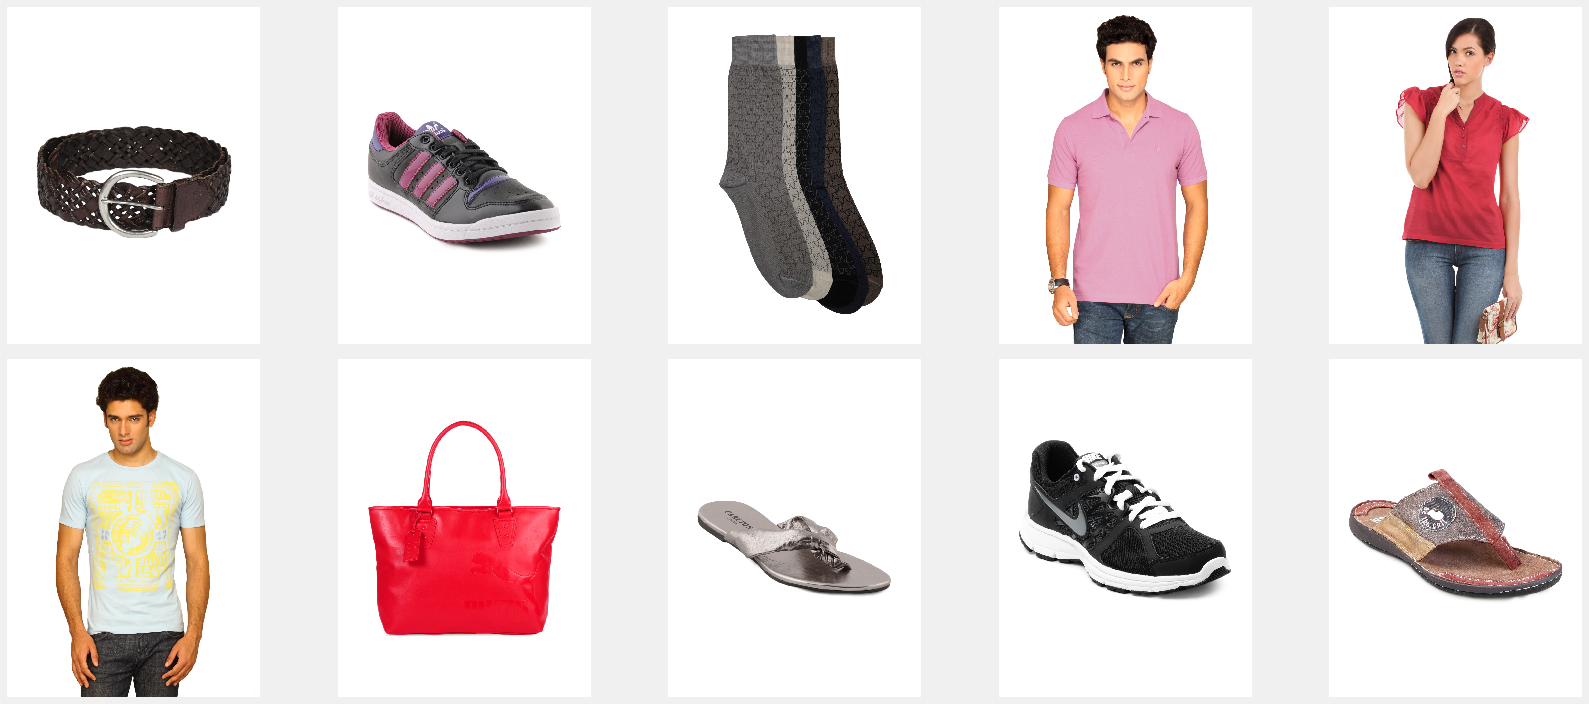

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))

random_img = style_df['image_path'].sample(10).values
random_img = [cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB) for i in random_img]

for idx, img in enumerate(random_img):
    if idx <= 4:
        axes[0, idx].imshow(img)
        axes[0, idx].axis('off')
    else:
        axes[1, idx-5].imshow(img)
        axes[1, idx-5].axis('off')
        
plt.tight_layout()
plt.show()

# Convolutional Neural Network (CNN) — Deep Learning

<hr>

CNN is a class of deep neural networks which is mostly used to do image recognition / classification, object detection, style transfer etc. In CNN, we take an image as an input, assign importance (learnable weights and biases) to its various aspects/objects in the image and be able to differentiate one from another.

Computers see images differently than humans. they see images as pixels / matrix.

![computer-see-image](https://miro.medium.com/max/1272/0*bUvnIM6LTtdn_S3W.png)

-----------------------------------------------

### CNN performs a dot product between two matrices: each value in each pixel of input image with filter.

![convolution](https://miro.medium.com/max/1000/1*GcI7G-JLAQiEoCON7xFbhg.gif)

The main objective of convolution is to extract features such as edges, colours, corners from the input. As we go deeper inside the network (with max pooling), the network starts identifying more complex features such as shapes,digits, face parts as well. Last, CNN do the classification process using Fully-Connected Layer.

![architecture](https://miro.medium.com/max/1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

# My Experiment
    
* In his [original notebook](https://www.kaggle.com/marlesson/building-a-recommendation-system-using-cnn-v2), Marlesson used ResNet50 for extract 5000 images
* In this notebook i used EfficientNet B3 for extract 15000 images
*  Actually i already tried ResNet50, Xception too, in my opinion, the result is the same, but i recommend you to try by yourself if you're interested :)

## Model 1 - Resnet50

In [10]:
# from tensorflow.keras.applications.resnet50 import ResNet50

# resnet50_model = ResNet50(weights='imagenet',
#                  include_top=False,
#                  input_shape=(224, 224, 3),
#                  pooling='max')

# resnet50_model.trainable = False

# resnet50_model.summary()

## Model 2 - Xception

In [11]:
# from tensorflow.keras.applications.xception import Xception

# xception_model = Xception(weights='imagenet',
#                           include_top=False,
#                           pooling='max')

# xception_model.trainable = False

# xception_model.summary()

## Model 3 - Efficient-Net

In May 2019, Google published both a very exciting paper and source code for a newly designed CNN called EfficientNet, that set new records for both accuracy and computational efficiency. Here’s the results of EfficientNet, scaled to different block layers (B1, B2, etc) vs. most other popular CNN’s.

![Architecture](https://miro.medium.com/max/985/1*nQ5HYZ1xiIGn092Y5H5SIQ.jpeg)

As the image shows, EfficientNet tops the current state of the art both in accuracy and in computational efficiency. How did they do this?

### Model scaling

They learned that CNN’s must be scaled up in **depth, width, and input image resolution together** to improve the performance of the model. The scaling method is named **compound scaling** and suggests that instead of scaling only one model attribute out of depth, width, and resolution; strategically scaling all three of them together delivers better results.

There is a synergy in scaling depth, width and image-resolution together, and after an extensive grid search derived the theoretically optimal formula of “compound scaling” using the following co-efficients:

* Depth = 1.20
* Width = 1.10
* Resolution = 1.15

Depth simply means how deep the networks is which is equivalent to the number of layers in it. Width simply means how wide the network is. One measure of width, for example, is the number of channels in a Conv layer whereas Resolution is simply the image resolution that is being passed to a CNN.

In other words, to scale up the CNN, the depth of layers should increase 20%, the width 10% and the image resolution 15% to keep things as efficient as possible while expanding the implementation and improving the CNN accuracy. This compound scaling formula is used to scale up the EfficientNet from B0-B7

### Swish Activation

![swish-activation](https://miro.medium.com/max/1400/0*EhAHcCmGOzQUgQ0k)

ReLu works pretty well but it got a problem, it nullifies negative values and thus derivatives are zero for all negative values. There are many known alternatives to tackle this problem like leaky ReLu, Elu, Selu etc., but none of them has proven consistent.

Google Brain team suggested a newer activation that tends to work better for deeper networks than ReLU which is a Swish activation. They proved that if we replace Swish with ReLu on InceptionResNetV2, we can achieve 0.6% more accuracy on ImageNet dataset.

> Swish(x) = x * sigmoid(x)

There are other things like MBConv Block etc. If you want to know more details, you can read the articles in reference below

In [12]:
!pip install -q efficientnet

### In efficientNet, depth, width, and input image resolution must scaled up together

We cannot randomly adjust the resolution. I read in an article, every efficientnet model has a different image resolution input size.

* efficientnet-b0-224

* efficientnet-b1-240

* efficientnet-b2-260

* efficientnet-b3-300

* efficientnet-b4-380

* efficientnet-b5-456

* efficientnet-b6-528

* efficientnet-b7-600

In [114]:
from efficientnet.tfkeras import EfficientNetB4

efficientnet_model = EfficientNetB4(weights='imagenet',
                                        include_top=False,
                                        pooling='avg') # max

efficientnet_model.trainable = False

# efficientnet_model.summary()

In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from efficientnet.tfkeras import center_crop_and_resize, preprocess_input
# from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
# from tensorflow.keras.applications.xception import preprocess_input

# ResNet use (224, 224)
# Xception use (299, 299)
# EfficientNet B3 i use (300, 300)
# EfficientNet B4 i use (380, 380)

def get_embedding(model, img_path):
    
    img = load_img(img_path, target_size=(380, 380))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    return model.predict(img).reshape(-1)

In [15]:
def show_image(img):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(14, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [16]:
img_embed = get_embedding(efficientnet_model, style_df.iloc[4548].image_path)

print('Image shape after embedding:', img_embed.shape)
print(img_embed)

Image shape after embedding: (1792,)
[-0.14361735 -0.11709114 -0.16867556 ... -0.13129158 -0.15261875
 -0.09174284]


Output shape comparison:

* Resnet50: 2048
* Xception: 2048
* EfficientNet B3: 1536
* EfficientNet B4: 1792

> ## There is two image that error when opened, since it will making training crash, we should drop this

In [17]:
style_df.drop([6695, 16194, 32309, 36381, 40000], inplace=True)

In [18]:
style_df.reset_index(drop=True, inplace=True)

## Train using Google Cloud with GPU (P100)

* duration: approximate 100 minutes
* cost: approximate 3 US Dollar

In [19]:
# %%time

# map_embeddings = style_df['image_path'].apply(lambda img_path: get_embedding(efficientnet_model, img_path))
# df_embs = map_embeddings.apply(pd.Series)

In [20]:
# df_embs.to_csv('embedding_result_full.csv', index=False)

In [21]:
# load the model
df_embs = pd.read_csv('/kaggle/input/fashion-embedding-weights-in-csv/embedding_result_full.csv')

print('df_embs shape:', df_embs.shape)

df_embs shape: (44419, 1792)


## Visual Search using KNN

* Load image from internet

In [22]:
from sklearn.neighbors import NearestNeighbors
# https://www.kaggle.com/ajax0564/reverse-image-search-with-tensorflow-2-2/comments

neighbors = NearestNeighbors(n_neighbors=8,
                             algorithm='ball_tree',
                             metric='euclidean')

neighbors.fit(df_embs)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                 radius=1.0)

In [23]:
import urllib.request as req

def load_image(img):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def visual_search(url):
    
    # first, load image from google search
    f = open('img_from_url.jpg', 'wb')
    f.write(req.urlopen(url).read())
    f.close()
    
    _, indices = neighbors.kneighbors(get_embedding(efficientnet_model, 'img_from_url.jpg').reshape(1, -1))
    indices = indices.ravel()
    
    plt.imshow(load_image('img_from_url.jpg'))
    plt.title('Downloaded image')
    plt.axis('off')
    
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 10))
    
    for idx, ind in enumerate(indices):
        axes.ravel()[idx].imshow(load_image(style_df.iloc[ind].image_path))
        axes.ravel()[idx].set_axis_off()
    plt.tight_layout()

In [24]:
# https://www.befren.com/wp-content/uploads/2019/03/15-Wanita-India-Paling-Cantik-Tahun-Ini-Siapakah-Favoritmu-befren.com_.jpg
# https://www.static-src.com/wcsstore/Indraprastha/images/catalog/medium//98/MTA-3467861/adidas_adidas-men-running-response-tee-pakaian-olahraga-pria--ce7262-_full02.jpg?output-format=webp
# https://i2.wp.com/kreativv.com/wp-content/uploads/2019/12/Jenis-celana-wanita-5.jpg?resize=500%2C500&ssl=1
# https://id-test-11.slatic.net/p/993bf8707f80deade9ce2ab94bacc1e5.jpg
# https://ae01.alicdn.com/kf/HTB1q9rAPVXXXXXyXpXXq6xXFXXXE/Wanita-Lengan-Panjang-Gaun-Mini-Fashion-Baru-Hitam-Merah-Gaun-Wanita-Pakaian-Kerja-Gaun-Elegan-Formal.jpg_Q90.jpg_.webp
# https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTh7s6a-dLeMCmjN8MdlvQuCJR6msMWgUb4DA&usqp=CAU
# https://asset.kompas.com/crops/So0-8oeVzEM9OjPes3qxQeTPbuQ=/0x0:915x610/750x500/data/photo/2018/12/09/3650048465.jpg
# https://dynamic.zacdn.com/hTbYxRw29197sSGnGQPx2B5Xm90=/fit-in/346x500/filters:quality(90):fill(ffffff)/http://static.id.zalora.net/p/you-ve-0655-8220242-1.jpg

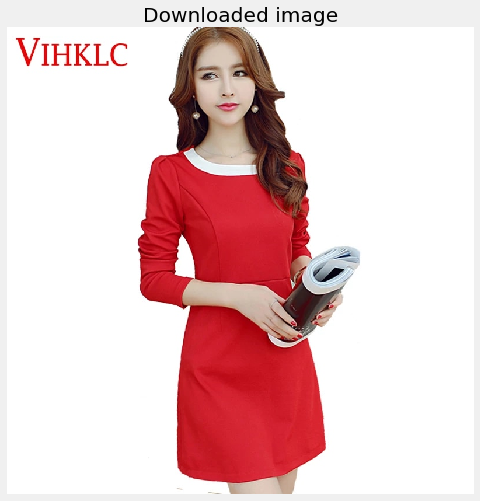

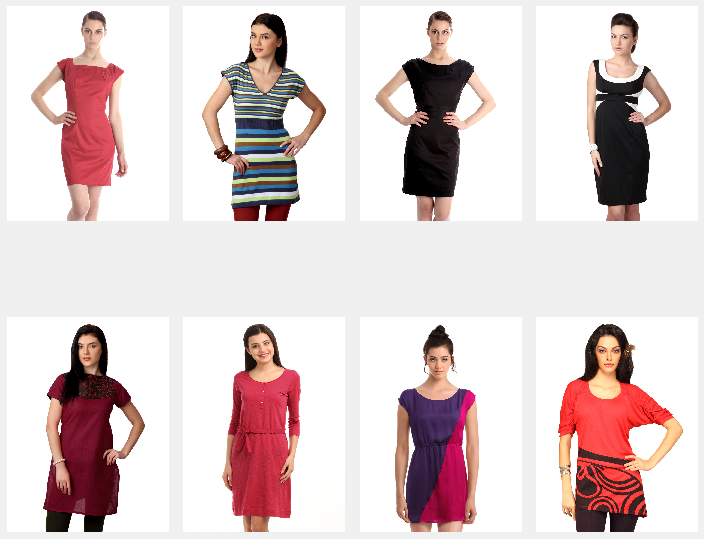

In [25]:
visual_search('https://ae01.alicdn.com/kf/HTB1q9rAPVXXXXXyXpXXq6xXFXXXE/Wanita-Lengan-Panjang-Gaun-Mini-Fashion-Baru-Hitam-Merah-Gaun-Wanita-Pakaian-Kerja-Gaun-Elegan-Formal.jpg_Q90.jpg_.webp')

## Using Sportify Annoy for handle huge dataset

* So far so good; however, at the moment we are only working with a small dataset
* If we use huge dataset, it will be very slow!
* A quick way of speeding things up is to reduce the size of the feature vectors using PCA
* Then replace KNN with Annoy

<hr>

http://www.numerately.com/blog/creating-a-visual-search-engine-using-pytorch/

https://www.kaggle.com/nicw102168/nearest-neighbor-classification-with-annoy

In [26]:
from annoy import AnnoyIndex
from sklearn.decomposition import PCA
import joblib

# First, PCA reduce dimension size from 1792 to 128

pca = PCA(n_components=128) # 128 dimensions
components = pca.fit_transform(df_embs)

# joblib.dump(pca, 'pca.joblib')

### Tradeoffs

* number_of_trees — a larger value will give more accurate results, but larger indexes.
* search_k — a larger value will give more accurate results, but will take a longer time to return.

In [27]:
index = AnnoyIndex(128, 'angular') # also use 128 dimensions
for i, j in enumerate(components):
    index.add_item(i, j)

index.build(15) # Ntrees
# index.save('index.annoy')

True

In [28]:
def annoy_visual_search(url):
    
    f = open('img_from_url.jpg', 'wb')
    f.write(req.urlopen(url).read())
    f.close()
    
    # remember we use PCA
    components_load = pca.transform(get_embedding(efficientnet_model, 'img_from_url.jpg').reshape(1, -1)).ravel()

    indices = index.get_nns_by_vector(components_load, 8, search_k=-1, include_distances=False) # 8 images
    indices = np.array(indices)
    
    plt.imshow(load_image('img_from_url.jpg'))
    plt.title('Downloaded image')
    plt.axis('off')
    
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 10))
    
    for idx, ind in enumerate(indices):
        axes.ravel()[idx].imshow(load_image(style_df.iloc[ind].image_path))
        axes.ravel()[idx].set_axis_off()
    plt.tight_layout()

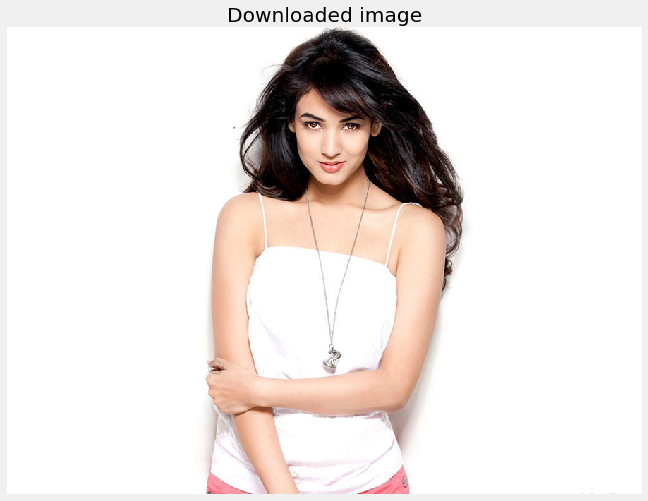

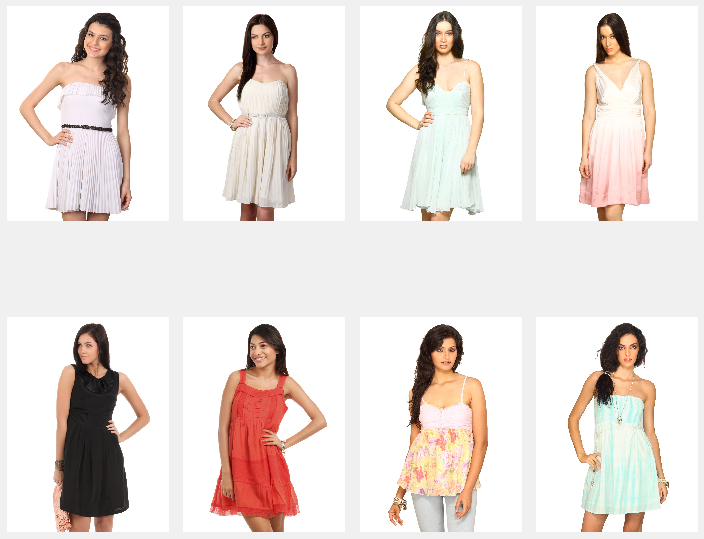

In [29]:
annoy_visual_search('https://www.befren.com/wp-content/uploads/2019/03/15-Wanita-India-Paling-Cantik-Tahun-Ini-Siapakah-Favoritmu-befren.com_.jpg')

In [30]:
# annoy_visual_search('')

## Make Recommendation Engine using Cosine Similarity (traditional way)

* Works for small dataset
* Sometimes will give us better accuracy

Need large RAM and slow for large dataset

In [32]:
### load 20k
df_embs2 = pd.read_csv('/kaggle/input/fashion-embedding-weights-in-csv/fashion_embedding_effnet_avg20.csv')

In [33]:
from sklearn.metrics.pairwise import pairwise_distances

# Calculate Distance Matrix
cosine_sim = 1 - pairwise_distances(df_embs2, metric='cosine')
cosine_sim[:4, :4]

array([[1.        , 0.58418372, 0.0279379 , 0.54352129],
       [0.58418372, 1.        , 0.01060365, 0.68061038],
       [0.0279379 , 0.01060365, 1.        , 0.05951061],
       [0.54352129, 0.68061038, 0.05951061, 1.        ]])

## Make a function

In [34]:
indices = pd.Series(range(len(style_df)), index=style_df.index)

# Function to get recommendations based on the cosine similarity score
def get_recommender(idx, top_n = 6):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1: top_n+1]
    
    idx_rec    = [i[0] for i in sim_scores] # index
    idx_sim    = [i[1] for i in sim_scores] # similarity
    
    return indices.iloc[idx_rec].index, idx_sim

def load_image(img):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def plot_figures(figures, nrows = 2, ncols=3, figsize=(8, 8)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    for ind, title in enumerate(figures):
        # walaupun 2x3 tetap bisa di-loop klo di-ravel
        axes.ravel()[ind].imshow(figures[title])
        axes.ravel()[ind].set_title(title)
        axes.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

In [35]:
def show_recommender(idx):
    '''
    Function: Give a recommendation based on similarity between product image
    Input: image index (number between 0 - 14998)
    '''
    
    # Recommendations
    idx_rec, idx_sim = get_recommender(idx)
    
    # Plot
    plt.imshow(load_image(style_df.iloc[idx].image_path))
    plt.title(style_df.iloc[idx].productDisplayName)
    plt.axis('off')
    
    # generation of a dictionary of (title, images)
    figures = {'im ' + str(i): load_image(row.image_path) for i, row in style_df.loc[idx_rec].iterrows()}
    
    # plot of the images in a figure, with 2 rows and 3 columns
    plot_figures(figures)

## Show recommendation results

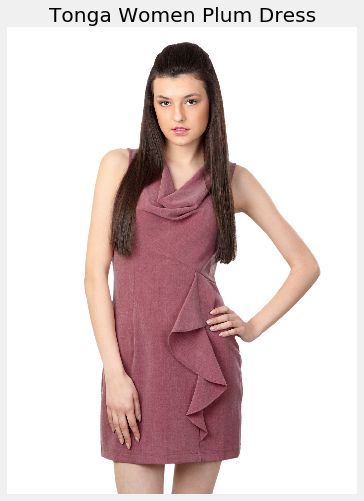

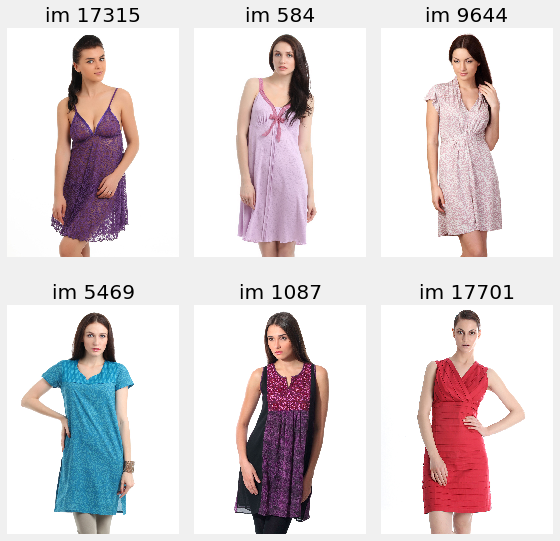

In [36]:
show_recommender(12823)

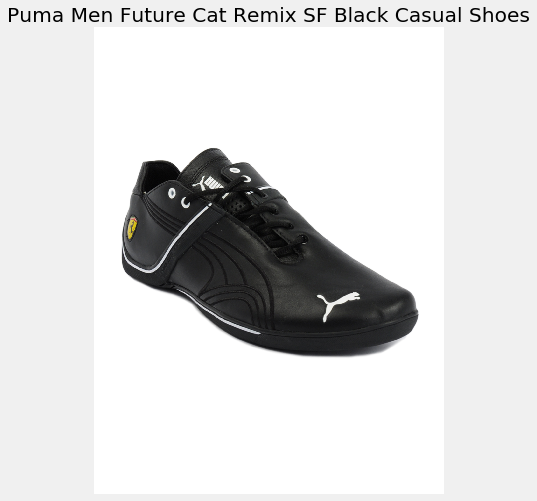

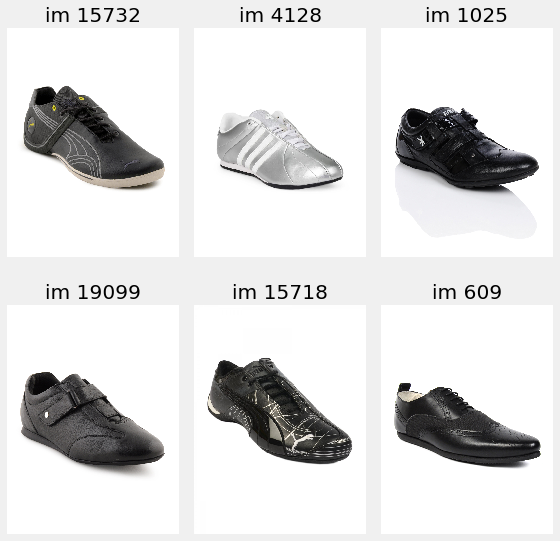

In [37]:
show_recommender(10)

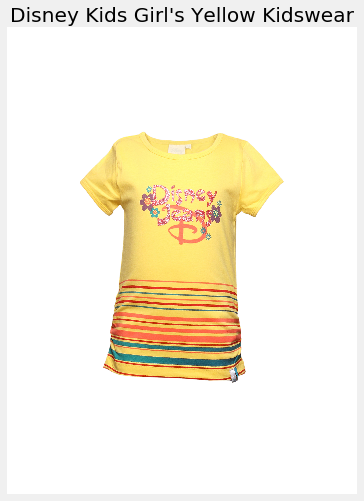

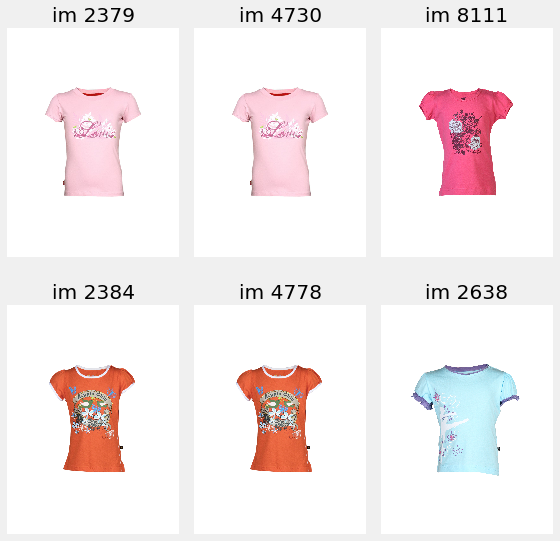

In [38]:
show_recommender(14500)

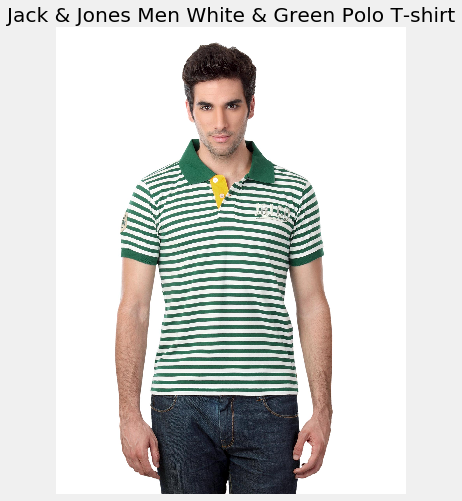

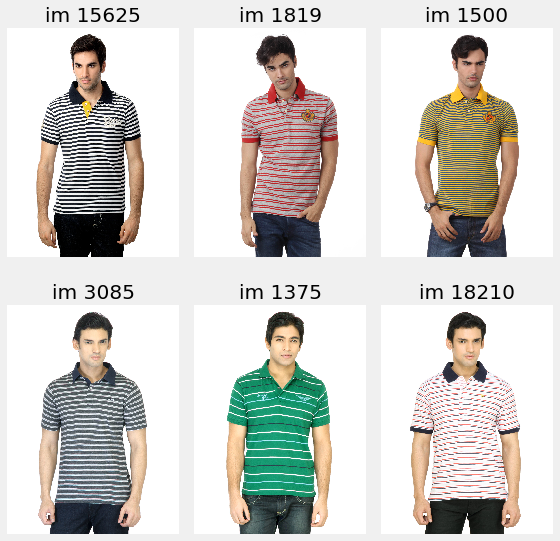

In [39]:
show_recommender(13321)

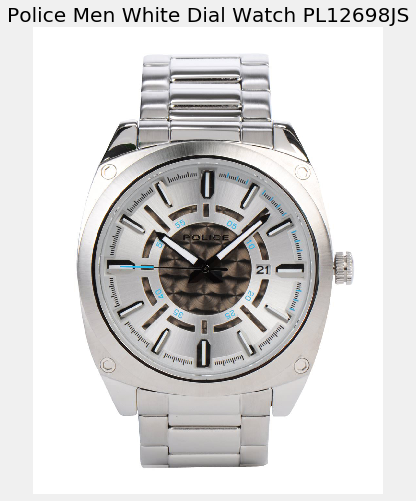

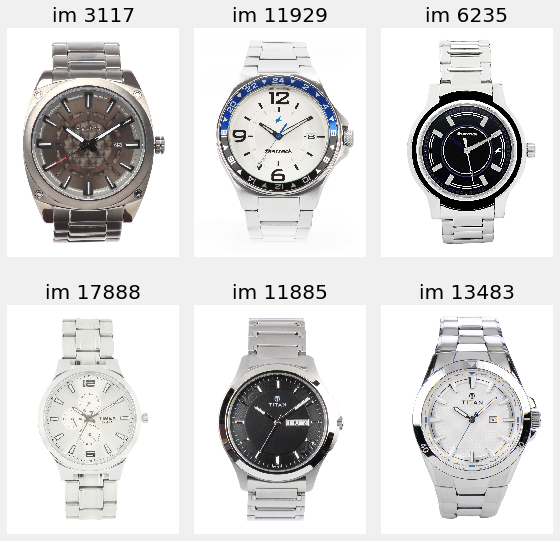

In [40]:
show_recommender(223)

## Recommendation Engine use Annoy for the rescue!

* Works for large dataset
* Faster
* But sometimes it will give lower accuracy

Anyway, Annoy will save memory and give faster prediction (better in my perspective)

In [67]:
def get_annoy_rec(idx, top_n = 6):
    
    components_load = pca.transform(df_embs.iloc[idx].values.reshape(1, -1)).ravel()
    
    indices = index.get_nns_by_vector(components_load, top_n+1, search_k=-1, include_distances=False)
    indices = np.array(indices)
    
    return indices[1:] # exclude index 0

def load_image(img):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def plot_figures(figures, nrows = 2, ncols=3, figsize=(8, 8)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    for ind, title in enumerate(figures):
        # walaupun 2x3 tetap bisa di-loop klo di-ravel
        axes.ravel()[ind].imshow(figures[title])
        axes.ravel()[ind].set_title(title)
        axes.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def show_recommender_annoy(idx):
    '''
    Function: Give a recommendation based on similarity between product image
    Input: image index (number between 0 - 14998)
    '''
    
    # Recommendations
    idx_rec = get_annoy_rec(idx)
    
    # Plot
    plt.imshow(load_image(style_df.iloc[idx].image_path))
    plt.title(style_df.iloc[idx].productDisplayName)
    plt.axis('off')
    
    # generation of a dictionary of (title, images)
    figures = {'im ' + str(i): load_image(row.image_path) for i, row in style_df.loc[idx_rec].iterrows()}
    
    # plot of the images in a figure, with 2 rows and 3 columns
    plot_figures(figures)

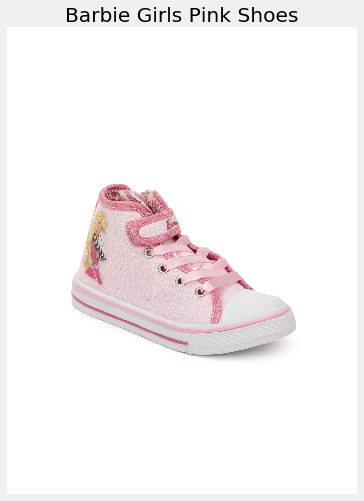

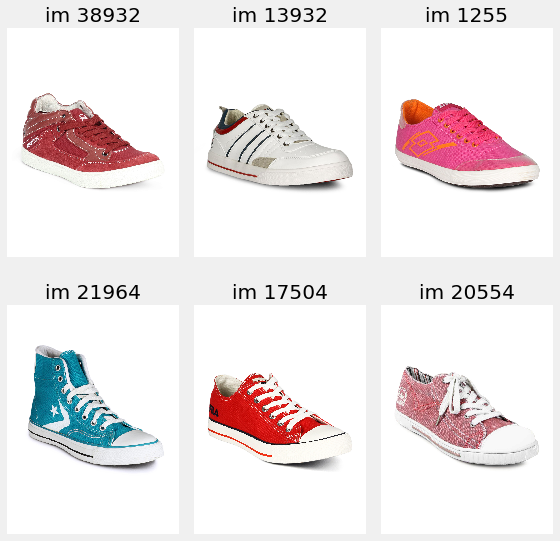

In [75]:
show_recommender_annoy(3223)

In [43]:
############################

## Use Metadata (change to annoy) - HOMEWORK

In [113]:
style_df.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  \
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt   
1  2012.0  Casual             Peter England Men Party Blue Jeans   
2  2016.0  Casual                       Titan Women Silver Watch   
3  2011.0  Casual  Manchester United Men Solid Black Track Pants   
4  2012.0  Casual                          Puma Men Grey T-shirt   

                                          image_path  
0  /kaggle/input/fashion-product-images-dataset/f...  
1  /kaggle/input/fashion-product-images-dataset/f...  
2  /kaggle/input/fashion-product-images-dataset/f...  
3  /kaggle/input/fashion-product-images-dataset/f...  
4  /kaggle/input/fashion-product-images-dataset/f...

### Options

* Sort by year - newest product

* filter by spesific season / usage

* etc

In [110]:
def get_annoy_rec_meta(idx, top_n = 12):
    
    components_load = pca.transform(df_embs.iloc[idx].values.reshape(1, -1)).ravel()
    
    indices = index.get_nns_by_vector(components_load, top_n+1, search_k=-1, include_distances=False)
    indices = np.array(indices)[1:]
    
    ## benerin filtering
    ## pastikan gender bener
    
    df = style_df.loc[indices].sort_values(by='year', ascending=False) # newest product
    final_indices = df.index.tolist()[:6]
    
    return final_indices

def plot_figures(figures, nrows = 2, ncols=3, figsize=(8, 8)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    for ind, title in enumerate(figures):
        # walaupun 2x3 tetap bisa di-loop klo di-ravel
        axes.ravel()[ind].imshow(figures[title])
        axes.ravel()[ind].set_title(title)
        axes.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def show_recommender_annoy_meta(idx):
    '''
    Function: Give a recommendation based on similarity between product image
    Input: image index (number between 0 - 14998)
    '''
    
    # Recommendations
    idx_rec = get_annoy_rec_meta(idx)
    
    # Plot
    plt.imshow(load_image(style_df.iloc[idx].image_path))
    plt.title(style_df.iloc[idx].productDisplayName)
    plt.axis('off')
    
    # generation of a dictionary of (title, images)
    figures = {'im ' + str(i): load_image(row.image_path) for i, row in style_df.loc[idx_rec].iterrows()}
    
    # plot of the images in a figure, with 2 rows and 3 columns
    plot_figures(figures)

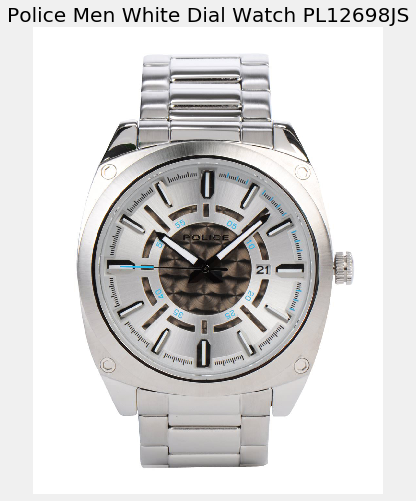

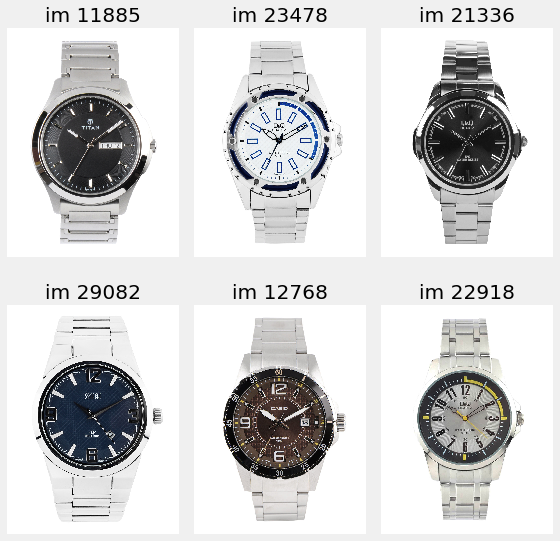

In [112]:
show_recommender_annoy_meta(223)

# Reference:

<hr>

[Original Notebook](https://www.kaggle.com/marlesson/building-a-recommendation-system-using-cnn-v2)

[EfficientNet from Google — Optimally Scaling CNN model architectures with “compound scaling”](https://medium.com/@lessw/efficientnet-from-google-optimally-scaling-cnn-model-architectures-with-compound-scaling-e094d84d19d4)

[Image Classification with EfficientNet: Better performance with computational efficiency](https://medium.com/analytics-vidhya/image-classification-with-efficientnet-better-performance-with-computational-efficiency-f480fdb00ac6)

[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://medium.com/@nainaakash012/efficientnet-rethinking-model-scaling-for-convolutional-neural-networks-92941c5bfb95)